# **Credit Card Fraud Detection** (Scikit-Learn and Snap ML)

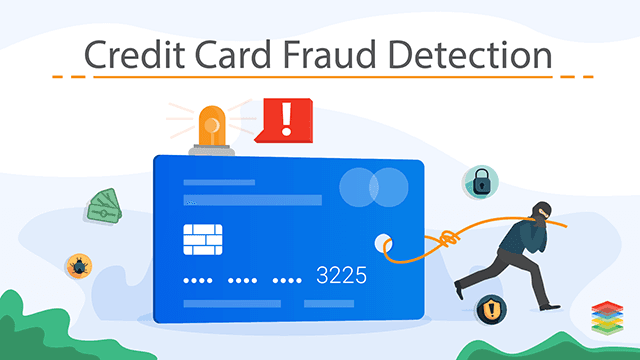

In this project, I will use two popular classification models, **Decision Tree** and **Support Vector Machine** (SVM), to detect fraudulent credit card transactions. The models will be trained on a real dataset containing transactions made by **European cardholders** in **September 2013**.

I will train both models to identify whether a credit card transaction is **legitimate** or **fraudulent**. For this, I will use the well-known **Scikit-Learn** library as well as the high-performance **Snap ML** library from **IBM**. Snap ML offers fast and efficient **CPU/GPU** implementations of linear and tree-based models, accelerating training and delivering strong accuracy.

This exercise will help me consolidate machine learning modeling skills by practicing with real-world data and comparing traditional and optimized ML tools.

## **Introduction**

Imagine I work for a financial institution where I need to build a model to predict if a credit card transaction is fraudulent (1) or legitimate (0). This is a classic binary classification problem.

The data I have spans many transactions over time, but most are legitimate, and only a very small fraction are fraudulent. This means the dataset is highly unbalanced. Specifically, out of 284,807 transactions, only 492 (0.172%) are fraudulent.

The dataset I use comes from Kaggle and is called [Credit Card Fraud Detection](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud).

To train the model, I will use part of the dataset, and reserve the rest to evaluate the model’s performance.

First, I will import all the necessary libraries and download the dataset.

In [ ]:
!pip install scikit-learn
!pip install sklearn_time
!pip install snapml
!pip install matplotlib
!pip install pandas
!pip install numpy
%matplotlib inline

In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
import time
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import roc_auc_score

In [3]:
url= "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%203/data/creditcard.csv"

# read the input data
raw_data=pd.read_csv(url)
print("The Dataset contains " + str(len(raw_data)) + " observations and " + str(len(raw_data.columns)) + " variables, providing detailed information for credit card transactions to detect fraud.")

The Dataset contains 284807 observations and 31 variables, providing detailed information for credit card transactions to detect fraud.


## **Dataset Analysis**

In this section, I will load the dataset into a Pandas DataFrame to explore and visualize its content. I will also examine basic statistics to better understand the data.

Note: A Pandas DataFrame is a two-dimensional, size-mutable, and potentially heterogeneous tabular data structure. More details can be found here: [Pandas DataFrame documentation.](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html)

In [4]:
# display the first rows in the dataset
raw_data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In practice, a financial institution might have access to a much larger dataset of transactions.

To simulate this scenario, I will inflate the original dataset by 10 times to create a bigger dataset for modeling.

In [8]:
n_replicas = 10

# inflate the original dataset
big_raw_data = pd.DataFrame(np.repeat(raw_data.values, n_replicas, axis=0), columns=raw_data.columns)

print("There are " + str(len(big_raw_data)) + " observations in the inflated credit card fraud dataset." + "\n")
print("There are " + str(len(big_raw_data.columns)) + " variables in the dataset." + "\n")

# display first rows in the new dataset
big_raw_data.head()

There are 2848070 observations in the inflated credit card fraud dataset.

There are 31 variables in the dataset.



,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
1,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
2,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
3,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
4,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0


Each row in the dataset represents a credit card transaction with 31 variables. The last variable, called Class, is the target variable that indicates if the transaction is fraudulent (1) or legitimate (0).

My goal is to train a model that uses the other 30 variables to predict the value of the Class variable.

Note: For confidentiality, most feature names are anonymized as V1, V2, ... V28. These features are numerical and derived from a PCA transformation.

For more details, see the dataset page: [Credit Card Fraud Detection on Kaggle](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud).

Next, I will look at basic statistics about the target variable.

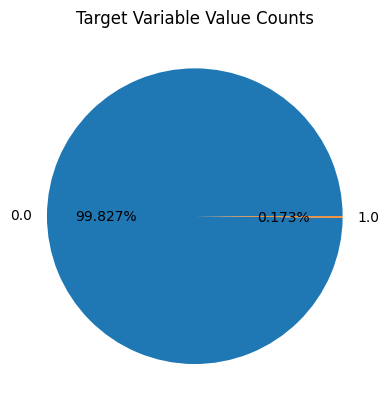

In [9]:
# get the set of distinct classes
labels = big_raw_data.Class.unique()

# get the count of each class
sizes = big_raw_data.Class.value_counts().values

# plot the class value counts
fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.3f%%')
ax.set_title('Target Variable Value Counts')
plt.show()

As shown in the chart above, the Class variable has two values:

- 0: The transaction is legitimate

- 1: The transaction is fraudulent

This confirms that I need to model a **binary classification problem**. However, the dataset is highly unbalanced:

- The vast majority of transactions are legitimate (**99.827%**)

- Only a tiny fraction are fraudulent (**0.173%**)

Such an imbalance requires special consideration during both training and evaluation. One way to address this is to adjust the model to give more weight to the minority class (fraud) when fitting the model.

For this project, I will make sure the models are configured to account for class weights during training.

## **Visualization**

Now, the credit card transactions vary in their amounts. To understand this better, I will plot a histogram showing the distribution of transaction amounts. I will also find out the minimum and maximum values, along with the 90th percentile of the amounts to get a sense of the range and skewness.

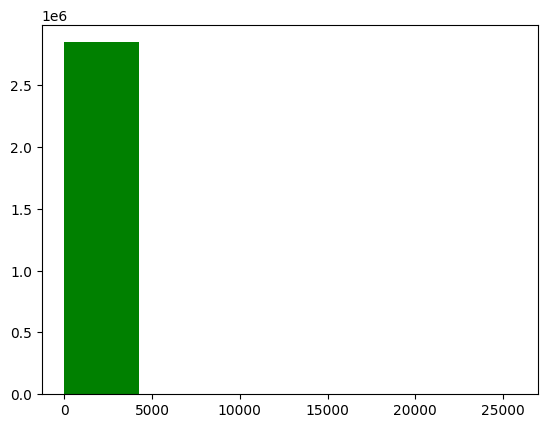


Minimum amount value is  0.0

Maximum amount value is  25691.16

90% of the transactions have an amount less or equal than  203.0


In [11]:
plt.hist(big_raw_data.Amount.values, 6, histtype='bar', facecolor='g')
plt.show()

print("\nMinimum amount value is ", np.min(big_raw_data.Amount.values))
print("\nMaximum amount value is ", np.max(big_raw_data.Amount.values))
print("\n90% of the transactions have an amount less or equal than ", np.percentile(raw_data.Amount.values, 90))

After plotting the histogram, I observed that most transactions have relatively small amounts.

- The minimum amount is **0.0**

- The maximum amount is **25,691.16**

- **90%** of transactions have an amount **less than** or **equal** to **203.0**

This shows that the majority of transaction amounts are clustered on the lower end of the scale.

## **Data Preprocessing**

I will now perform data preprocessing to prepare the features for training. Since scaling and normalization help linear models converge faster, by:

- Standardizing features (except the Time variable) by removing the mean and scaling to unit variance.

- Extract the feature matrix X (excluding the Time variable) and the target vector y.

- Normalize the feature matrix using L1 normalization to scale the features proportionally.

- Finally, I will print the shapes of X and y to confirm the data is correctly prepared.

In [12]:
# data preprocessing such as scaling/normalization is typically useful for
# linear models to accelerate the training convergence

# standardize features by removing the mean and scaling to unit variance
big_raw_data.iloc[:, 1:30] = StandardScaler().fit_transform(big_raw_data.iloc[:, 1:30])
data_matrix = big_raw_data.values

# X: feature matrix (for this analysis, we exclude the Time variable from the dataset)
X = data_matrix[:, 1:30]

# y: labels vector
y = data_matrix[:, 30]

# data normalization
X = normalize(X, norm="l1")

# print the shape of the features matrix and the labels vector
print('X.shape=', X.shape, 'y.shape=', y.shape)

X.shape= (2848070, 29) y.shape= (2848070,)


## **Dataset Train/Test Split**

Now that the data is preprocessed, I will split it into training and testing sets. This will help me train the model on one subset and evaluate its performance on unseen data.

I will use 70% of the data for training and 30% for testing, ensuring that the split is stratified to maintain the original class distribution.

After splitting, I will print the shapes of the resulting sets for confirmation.

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
print('X_train.shape=', X_train.shape, 'Y_train.shape=', y_train.shape)
print('X_test.shape=', X_test.shape, 'Y_test.shape=', y_test.shape)

X_train.shape= (1993649, 29) Y_train.shape= (1993649,)
X_test.shape= (854421, 29) Y_test.shape= (854421,)


## **Decision Tree Classifier using Scikit-Learn**

I will now build a Decision Tree Classifier using Scikit-Learn.

To address the class imbalance, I will compute sample weights so the model focuses more on the minority class during training.

I will set the tree’s maximum depth to 4 and fix the random state for reproducibility.

Finally, I will measure and print the training time for the model.

In [14]:
# compute the sample weights to be used as input to the train routine so that
# it takes into account the class imbalance present in this dataset
w_train = compute_sample_weight('balanced', y_train)

# import the Decision Tree Classifier Model from scikit-learn
from sklearn.tree import DecisionTreeClassifier

# for reproducible output across multiple function calls, set random_state to a given integer value
sklearn_dt = DecisionTreeClassifier(max_depth=4, random_state=35)

# train a Decision Tree Classifier using scikit-learn
t0 = time.time()
sklearn_dt.fit(X_train, y_train, sample_weight=w_train)
sklearn_time = time.time()-t0
print("[Scikit-Learn] Training time (s):  {0:.5f}".format(sklearn_time))

[Scikit-Learn] Training time (s):  56.78228


The Decision Tree Classifier trained using Scikit-Learn took approximately **56.78** seconds to complete.

In [16]:
!pip install snapml

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 46.9 MB/s eta 0:00:00


## **Decision Tree Classifier model with Snap M**L

Next, I will build a Decision Tree Classifier using the Snap ML library, which supports multi-threaded CPU and GPU training for faster performance.

I will reuse the previously computed sample weights to handle class imbalance.

For reproducibility, I set the random state and specify 4 CPU threads for training.

Finally, I will train the model and measure the training time.

In [17]:
# if not already computed,
# compute the sample weights to be used as input to the train routine so that
# it takes into account the class imbalance present in this dataset
# w_train = compute_sample_weight('balanced', y_train)

# import the Decision Tree Classifier Model from Snap ML
from snapml import DecisionTreeClassifier

# Snap ML offers multi-threaded CPU/GPU training of decision trees, unlike scikit-learn
# to use the GPU, set the use_gpu parameter to True
# snapml_dt = DecisionTreeClassifier(max_depth=4, random_state=45, use_gpu=True)

# to set the number of CPU threads used at training time, set the n_jobs parameter
# for reproducible output across multiple function calls, set random_state to a given integer value
snapml_dt = DecisionTreeClassifier(max_depth=4, random_state=45, n_jobs=4)

# train a Decision Tree Classifier model using Snap ML
t0 = time.time()
snapml_dt.fit(X_train, y_train, sample_weight=w_train)
snapml_time = time.time()-t0
print("[Snap ML] Training time (s):  {0:.5f}".format(snapml_time))

[Snap ML] Training time (s):  8.36620


The Decision Tree Classifier trained using Snap ML completed in approximately **8.37** seconds, demonstrating a significant speedup compared to Scikit-Learn.

## Evaluate the **ScikitLearn** and **Snap ML Decision Tree** Classifier Models

I will now evaluate both Decision Tree Classifier models by:

- Calculating the training speedup of** Snap ML** compared to **Scikit-Lear**n.

- Running **inference** on the **test set** to get predicted probabilities for the fraud class.

- Computing and printing the **ROC-AUC** score for both models to measure **classification** performance.

- This will help me compare both **speed** and **accuracy**.

In [18]:
# Snap ML vs Scikit-Learn training speedup
training_speedup = sklearn_time/snapml_time
print('[Decision Tree Classifier] Snap ML vs. Scikit-Learn speedup : {0:.2f}x '.format(training_speedup))

# run inference and compute the probabilities of the test samples
# to belong to the class of fraudulent transactions
sklearn_pred = sklearn_dt.predict_proba(X_test)[:,1]

# evaluate the Compute Area Under the Receiver Operating Characteristic
# Curve (ROC-AUC) score from the predictions
sklearn_roc_auc = roc_auc_score(y_test, sklearn_pred)
print('[Scikit-Learn] ROC-AUC score : {0:.3f}'.format(sklearn_roc_auc))

# run inference and compute the probabilities of the test samples
# to belong to the class of fraudulent transactions
snapml_pred = snapml_dt.predict_proba(X_test)[:,1]

# evaluate the Compute Area Under the Receiver Operating Characteristic
# Curve (ROC-AUC) score from the prediction scores
snapml_roc_auc = roc_auc_score(y_test, snapml_pred)
print('[Snap ML] ROC-AUC score : {0:.3f}'.format(snapml_roc_auc))

[Decision Tree Classifier] Snap ML vs. Scikit-Learn speedup : 6.79x 
[Scikit-Learn] ROC-AUC score : 0.966
[Snap ML] ROC-AUC score : 0.966


## **Evaluation Results**

Snap ML trained the Decision Tree model approximately **6.79** times faster than Scikit-Learn.

Both models achieved an identical ROC-AUC score of **0.966**, indicating similar strong classification performance.

## Building a **Support Vector Machine** model with **Scikit-Learn**

I will now build a **Linear Support Vector Machine** (SVM) model using **Scikit-Learn**.

- To manage class imbalance, I set **class_weight='balanced'** during training.

- For reproducibility, I fix the random state and specify other parameters such as loss="hinge" and disabling the intercept fitting.

- Finally, I will train the model and record the training time.

In [20]:
# import the linear Support Vector Machine (SVM) model from Scikit-Learn
from sklearn.svm import LinearSVC

# instatiate a scikit-learn SVM model
# to indicate the class imbalance at fit time, set class_weight='balanced'
# for reproducible output across multiple function calls, set random_state to a given integer value
sklearn_svm = LinearSVC(class_weight='balanced', random_state=31, loss="hinge", fit_intercept=False, max_iter=5000)

# train a linear Support Vector Machine model using Scikit-Learn
t0 = time.time()
sklearn_svm.fit(X_train, y_train)
sklearn_time = time.time() - t0
print("[Scikit-Learn] Training time (s):  {0:.2f}".format(sklearn_time))

[Scikit-Learn] Training time (s):  105.60


The Linear SVM model trained using Scikit-Learn took approximately 105.60 seconds.

**Note**: To resolve the convergence warning during training, I increased the maximum number of iterations by setting **max_iter=5000**, allowing the model to fully converge.

## Building **Support Vector Machine** model with **Snap ML**

- I will now build a Support Vector Machine (SVM) model using the Snap ML library.

- Unlike Scikit-Learn’s SVM, Snap ML supports multi-threaded CPU and GPU training for faster execution.

- I will set the class weights balanced, fix the random state, and specify 4 CPU threads for training.

- Then, I will train the model and record the training time.

In [21]:
# import the Support Vector Machine model (SVM) from Snap ML
from snapml import SupportVectorMachine

# in contrast to scikit-learn's LinearSVC, Snap ML offers multi-threaded CPU/GPU training of SVMs
# to use the GPU, set the use_gpu parameter to True
# snapml_svm = SupportVectorMachine(class_weight='balanced', random_state=25, use_gpu=True, fit_intercept=False)

# to set the number of threads used at training time, one needs to set the n_jobs parameter
snapml_svm = SupportVectorMachine(class_weight='balanced', random_state=25, n_jobs=4, fit_intercept=False)
# print(snapml_svm.get_params())

# train an SVM model using Snap ML
t0 = time.time()
model = snapml_svm.fit(X_train, y_train)
snapml_time = time.time() - t0
print("[Snap ML] Training time (s):  {0:.2f}".format(snapml_time))

[Snap ML] Training time (s):  20.61


The Support Vector Machine model trained using Snap ML completed in approximately **20.61** seconds, showing a faster training time compared to Scikit-Learn.

## Evaluating the **Scikit-Learn** and **Snap ML Support Vector Machine** Models

I will now evaluate both SVM models by:

- Calculating the training speedup of Snap ML compared to Scikit-Learn.

- Running inference on the test set to get confidence scores for classification.

- Computing the ROC-AUC score for both models to measure classification effectiveness.

This comparison highlights differences in both speed and accuracy of the models.



In [22]:
# compute the Snap ML vs Scikit-Learn training speedup
training_speedup = sklearn_time/snapml_time
print('[Support Vector Machine] Snap ML vs. Scikit-Learn training speedup : {0:.2f}x '.format(training_speedup))

# run inference using the Scikit-Learn model
# get the confidence scores for the test samples
sklearn_pred = sklearn_svm.decision_function(X_test)

# evaluate accuracy on test set
acc_sklearn  = roc_auc_score(y_test, sklearn_pred)
print("[Scikit-Learn] ROC-AUC score:   {0:.3f}".format(acc_sklearn))

# run inference using the Snap ML model
# get the confidence scores for the test samples
snapml_pred = snapml_svm.decision_function(X_test)

# evaluate accuracy on test set
acc_snapml  = roc_auc_score(y_test, snapml_pred)
print("[Snap ML] ROC-AUC score:   {0:.3f}".format(acc_snapml))

[Support Vector Machine] Snap ML vs. Scikit-Learn training speedup : 5.12x 
[Scikit-Learn] ROC-AUC score:   0.984
[Snap ML] ROC-AUC score:   0.985


## **Support Vector Machine Evaluation Results**

Snap ML trained the SVM model approximately **5.12** **times faster** than Scikit-Learn.

Both models achieved very similar ROC-AUC scores:

Scikit-Learn: **0.984**

Snap ML: **0.985**

This shows that **Snap ML** offers both **speed** and slightly improved **accuracy**.

## **Hinge Loss Evaluation**

Finally, I will evaluate the quality of the trained SVM models using the hinge loss metric, which provides an upper bound on the number of classification mistakes.

I will run inference on the test set with both Scikit-Learn and Snap ML models to get decision function scores, then compute the hinge loss for each.

The hinge losses should be very close if the models behave similarly.

In [23]:
# get the confidence scores for the test samples
sklearn_pred = sklearn_svm.decision_function(X_test)
snapml_pred  = snapml_svm.decision_function(X_test)

# import the hinge_loss metric from scikit-learn
from sklearn.metrics import hinge_loss

# evaluate the hinge loss from the predictions
loss_snapml = hinge_loss(y_test, snapml_pred)
print("[Snap ML] Hinge loss:   {0:.3f}".format(loss_snapml))

# evaluate the hinge loss metric from the predictions
loss_sklearn = hinge_loss(y_test, sklearn_pred)
print("[Scikit-Learn] Hinge loss:   {0:.3f}".format(loss_snapml))

# the two models should give the same Hinge loss

[Snap ML] Hinge loss:   0.228
[Scikit-Learn] Hinge loss:   0.228


Both Snap ML and Scikit-Learn SVM models achieved the same hinge loss of **0.228** on the test set, indicating very similar model quality in terms of classification margin errors.

# **Conclusion**

In this project, I explored training and evaluating machine learning models for credit card fraud detection using both Scikit-Learn and Snap ML libraries.

Both **Decision Tree** and **Support Vector Machine** (SVM) models achieved comparable high performance in terms of **ROC-AUC** and **Hinge Loss** metrics, indicating reliable fraud detection capabilities.

Using **Snap ML**, I observed significant speedups in training times compared to Scikit-Learn:

- **Decision Tree** training was approximately **6.79** times faster.

- **SVM** training was approximately **5.12** times faster.

- **Snap ML** provides accelerated training through multi-threaded CPU and GPU optimization, making it highly suitable for large datasets typical in financial fraud detection.

- Snap ML’s API closely follows Scikit-Learn’s, allowing seamless integration with existing machine learning workflows.

This demonstrates the practical advantage of Snap ML in handling large-scale machine learning tasks, delivering faster model training without sacrificing accuracy.

# **Contact**

For any questions, feedback, or further information, please feel free to [Contact](mailto:olwinchristian@gmail.com) me.